# MBA em Ciência de Dados e Inteligência Artificial - FIAP - 2024
# Projeto Integrado - Deep Learning

## Descrição do Projeto:

A QuantumFinance está desejando construir um fundo de ações baseado em modelos de Deep Learning. A ideia é desenvolver um modelo que tenha como saída a compra ou venda de uma determinada ação baseado na movimentação do mercado nos últimos 15 dias.

## O Desafio: 
A empresa deseja um modelo de Deep Learning que seja um ‘perseguidor de tendencia’, ou seja, se o papel sobe o modelo deve comprar, se o papel desce o
modelo deve vender. Para isso a QuantumFinance contratou economistas que fizerem a rotulagem dos dados baseado no valor de fechamento dos ativos. Inicialmente foi feita uma suavização dos preços de fechamento, e por se tratar de um assunto sigiloso, não foi informada a técnica de suavização utilizada. O próximo passo foi realizar a rotulagem dia a dia, para verificar qual devemos comprar e qual devemos vender.

Para esse notebook, contemplo uma arquitetura simples de redes utilizando CNN + LSTM. Essa arquitetura foi baseada em artigos para finalidade de estudo, disponíveis através do arquivo README.md, utilizando a ação VALE3 - Vale do Rio Doce para ajustes. Como bônus, abordo outras 3 ações (BBAS3 - Banco do Brasil, CSNA3 - Companhia Siderúrgica Nacional, PETR4 - Petrobras) para avaliar como a rede se comporta com outras ações.

In [1]:
from pathlib import Path 

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import plotly.graph_objects as go

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import ConfusionMatrixDisplay, recall_score, precision_score

from keras.models import Sequential
from keras.layers import Conv1D, BatchNormalization, MaxPooling1D, Dropout, Dense, LSTM, Bidirectional
from keras.regularizers import l1_l2
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras_tuner.tuners import Hyperband

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend


In [2]:
datapath = Path('../data')
modelpath = Path('../model')

In [3]:
data = pd.read_csv(f'{datapath}/csv/CSNA3train.csv')
data = data[['Date', 'Smoothed_Close', 'Label']]
data.head()

,Date,Smoothed_Close,Label
0,2000-01-24,1.588954,-1
1,2000-01-26,1.569864,-1
2,2000-01-27,1.550466,-1
3,2000-01-28,1.531815,-1
4,2000-01-31,1.511619,-1


In [4]:
data['Label'].value_counts()

-1    2655
 1    2088
Name: Label, dtype: int64

In [5]:
class LabelTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        X = X.copy()
        X.loc[X['Label'] == -1, 'Label'] = 0
        return X

In [6]:
data_test = pd.read_csv(f'{datapath}/csv/CSNA3test.csv')
data_test = data_test[['Smoothed_Close', 'Label']]

In [7]:
label_transformer = LabelTransformer()
data = label_transformer.fit_transform(data)
data_test = label_transformer.transform(data_test)

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4743 entries, 0 to 4742
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            4743 non-null   object 
 1   Smoothed_Close  4743 non-null   float64
 2   Label           4743 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 111.3+ KB


In [9]:
data['Date'] = pd.to_datetime(data['Date'])
data['Year'] = data['Date'].dt.year

In [10]:
fig = go.Figure()

for year in data['Year'].unique():
    year_data = data[data['Year'] == year]
    fig.add_trace(go.Scatter(x=year_data['Date'], y=year_data['Smoothed_Close'],
                             mode='lines', name=str(year)))

for label, name, color in zip([0, 1], ['Venda', 'Compra'], ['red', 'green']):
    label_data = data[data['Label'] == label]
    fig.add_trace(go.Scatter(x=label_data['Date'], y=label_data['Smoothed_Close'],
                             mode='markers', name=name, marker_color=color))

fig.update_layout(title='CSNA3 - Companhia Siderúrgica Nacional',
                  xaxis_title='Anos',
                  yaxis_title='Preços de Fechamento',
                  legend_title='Legenda')

fig.show()

In [11]:
data.drop(['Date', 'Year'], axis=1, inplace=True)

In [12]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_close = scaler.fit_transform(data[['Smoothed_Close']])
scaled_close_test = scaler.transform(data_test[['Smoothed_Close']])

In [13]:
data['Scaled_Close'] = scaled_close.flatten()
data_test['Scaled_Close'] = scaled_close_test.flatten()

In [14]:
def create_window(data, label, window_size=15):
    X, y = [], []
    
    for i in range(len(data) - window_size):
        window = data[i:(i + window_size)]
        cumulative_avg = np.mean(window)
        window = np.append(window, cumulative_avg)
        window = np.expand_dims(window, axis=-1)
        X.append(window)
        y.append(label[i + window_size])

    return np.array(X), np.array(y)

In [15]:
X_train, y_train = create_window(data=data['Scaled_Close'], label=data['Label'], window_size=15)
X_test, y_test = create_window(data=data['Scaled_Close'], label=data['Label'], window_size=15)

In [16]:
def rede_cnnTrading(hp):
    model = Sequential()
    model.add(Conv1D(
        filters=hp.Int('filters_1', min_value=32, max_value=64, step=32),
        kernel_size=hp.Choice('kernel_size_1', values=[2, 3]),
        activation=hp.Choice('activ1', values=['relu', 'tanh', 'elu']),
        padding='same', kernel_initializer='he_uniform', input_shape=(16, 1)))
    model.add(BatchNormalization())
    model.add(MaxPooling1D(pool_size=hp.Choice('pool1', values=[1, 2])))
    # model.add(Conv1D(
    #     filters=hp.Int('filters_2', min_value=32, max_value=128, step=32),
    #     kernel_size=hp.Choice('kernel_size_2', values=[2, 3]),
    #     activation=hp.Choice('activ2', values=['relu', 'tanh', 'elu']),
    #     padding='same', kernel_initializer='he_uniform'))
    # model.add(BatchNormalization())
    # model.add(MaxPooling1D(pool_size=hp.Choice('poo2', values=[1, 2])))
    # model.add(Conv1D(
    #     filters=hp.Int('filters_3', min_value=32, max_value=64, step=32),
    #     kernel_size=hp.Choice('kernel_size_3', values=[2, 3]),
    #     activation=hp.Choice('activ3', values=['relu', 'tanh', 'elu']),
    #     padding='same', kernel_initializer='he_uniform'))
    # model.add(MaxPooling1D(pool_size=hp.Choice('poo3', values=[1, 2])))
    # model.add(Bidirectional(LSTM(
    #     units=hp.Int('lstm_units1', min_value=50, max_value=100, step=50),
    #     activation=hp.Choice('actv3', values=['relu', 'tanh', 'elu']), return_sequences=True, kernel_initializer='he_uniform')))
    # model.add(Dropout(hp.Float('dropout_rate1', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Bidirectional(LSTM(
        units=hp.Int('lstm_units2', min_value=50, max_value=100, step=50),
        activation=hp.Choice('actv4', values=['relu', 'tanh', 'elu']), kernel_initializer='he_uniform')))
    # model.add(Dropout(hp.Float('dropout_rate2', min_value=0.0, max_value=0.5, step=0.1)))
    # model.add(TimeDistributed(Dense(units=1, activation=hp.Choice('activ2', values=['relu', 'tanh']), kernel_initializer='he_uniform')))
    model.add(Dropout(hp.Float('dropout_rate3', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(units=1, activation='sigmoid', kernel_initializer='he_uniform',
                                    kernel_regularizer=l1_l2(l1=hp.Float('l1', min_value=0.0, max_value=0.05, step=0.01), l2=hp.Float('l1', min_value=0.0, max_value=0.05, step=0.01))))
    model.compile(optimizer=Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-3, sampling='LOG')),
                  loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [17]:
tuner = Hyperband(
    rede_cnnTrading,
    objective='val_accuracy',
    max_epochs=100,
    directory=f'{modelpath}',
    project_name='hparam_tuning')

Reloading Tuner from ..\model\hparam_tuning\tuner0.json


In [18]:
es = EarlyStopping(monitor='loss', min_delta=1e-10, patience=10, verbose=1)
rlr = ReduceLROnPlateau(monitor='loss', factor=0.2, patience=5, verbose=1)
mcp = ModelCheckpoint(filepath=f'{modelpath}/pesosCSNA.h5', monitor='loss', save_best_only=True, verbose=1, mode='max')
callbacks = [es, rlr, mcp]

In [19]:
train_size = int(len(X_train) * 0.8)
X_train_split, X_val_split = X_train[:train_size], X_train[train_size:]
y_train_split, y_val_split = y_train[:train_size], y_train[train_size:]

In [ ]:
tuner.search(X_train, y_train, validation_data=(X_val_split, y_val_split), epochs=100, callbacks=[es, rlr, mcp], batch_size=1)

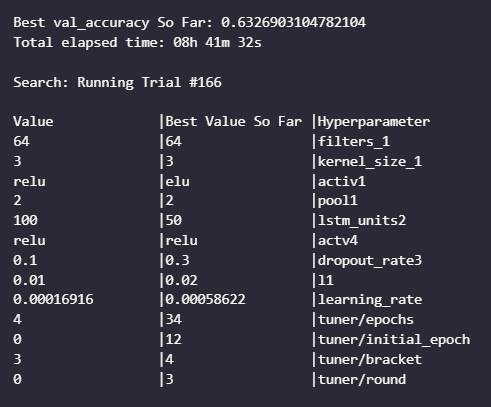

In [20]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation='elu', padding='same', kernel_initializer='he_uniform', input_shape=(16, 1)))
model.add(BatchNormalization())
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(units=50, activation='relu', kernel_initializer='he_uniform')))
model.add(Dropout(0.3))
model.add(Dense(units=1, activation='sigmoid', kernel_initializer='he_uniform', kernel_regularizer=l1_l2(l1=0.02, l2=0.02)))
model.compile(optimizer=Adam(learning_rate=0.00058622), loss='binary_crossentropy', metrics=['accuracy'])

In [21]:
TradingClassifierCSNA = model.fit(X_train_split, y_train_split, epochs=200, batch_size=1, validation_data=(X_val_split, y_val_split), callbacks=[es, rlr, mcp])

Epoch 1/200
3781/3782 [============================>.] - ETA: 0s - loss: 0.4981 - accuracy: 0.8231
Epoch 1: loss improved from -inf to 0.49794, saving model to ..\model\pesosCSNA.h5
3782/3782 [==============================] - 71s 13ms/step - loss: 0.4979 - accuracy: 0.8231 - val_loss: 7.1286 - val_accuracy: 0.6575 - lr: 5.8622e-04
Epoch 2/200
3778/3782 [============================>.] - ETA: 0s - loss: 0.3184 - accuracy: 0.8841
Epoch 2: loss did not improve from 0.49794
3782/3782 [==============================] - 50s 13ms/step - loss: 0.3183 - accuracy: 0.8839 - val_loss: 10.2047 - val_accuracy: 0.6321 - lr: 5.8622e-04
Epoch 3/200
3776/3782 [============================>.] - ETA: 0s - loss: 0.2820 - accuracy: 0.9004
Epoch 3: loss did not improve from 0.49794
3782/3782 [==============================] - 48s 13ms/step - loss: 0.2819 - accuracy: 0.9006 - val_loss: 11.6940 - val_accuracy: 0.6734 - lr: 5.8622e-04
Epoch 4/200
3779/3782 [============================>.] - ETA: 0s - loss: 0.2

In [22]:
model.evaluate(X_test, y_test)

148/148 [==============================] - 5s 9ms/step - loss: 3711.1218 - accuracy: 0.5025


[3711.121826171875, 0.5025380849838257]

In [23]:
predictions = model.predict(X_test).astype("int").flatten()

148/148 [==============================] - 4s 8ms/step


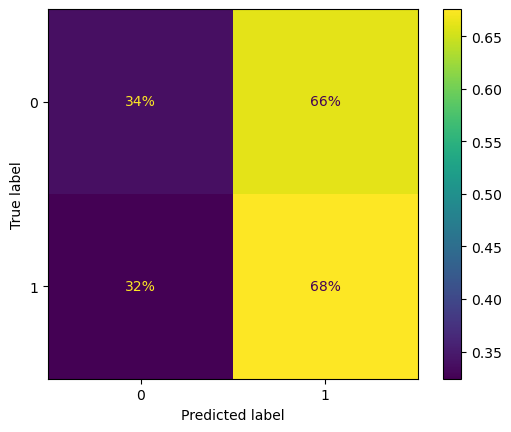

In [24]:
ConfusionMatrixDisplay.from_predictions(y_test, predictions, normalize='true', values_format='.0%')
plt.show()

In [25]:
print(f'Recall: {recall_score(y_test, predictions)}')
print(f'Precision: {precision_score(y_test, predictions)}')

Recall: 0.6757662835249042
Precision: 0.4469433006018372


In [26]:
model.save(f'{modelpath}/cnnTradingCSNA.h5')